In [7]:
# Inference: load artifacts and score test set (PD + bands/cluster)
from pathlib import Path
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import seaborn as sns


In [8]:
DATA_PATH = Path('/home/ali/repos/creadit_risk/customer_segmantation/outputs2/customer_segmantation_unbaked_dtree_v1/data/unbanked_customer_segmentation_final.csv')


Loaded model with K=7 bands, edges: [0.0015 0.0401 0.0968 0.134  0.189  0.263  0.328  0.92  ]
Loaded testing shape: (6319, 8)
Prepared testing data dimensions: (6319, 6)
risk_band
1            3347
2            1851
3             659
4             317
5             101
6              26
7              18
Name: count, dtype: int64
Saved: /home/ali/repos/creadit_risk/customer_segmantation/outputs2/customer_segmantation_unbaked_dtree_v1_datasource/testing_with_risk_bands.csv


/tmp/ipykernel_9177/2386490818.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=scored, x='risk_band', y='target', order=order, palette='viridis')


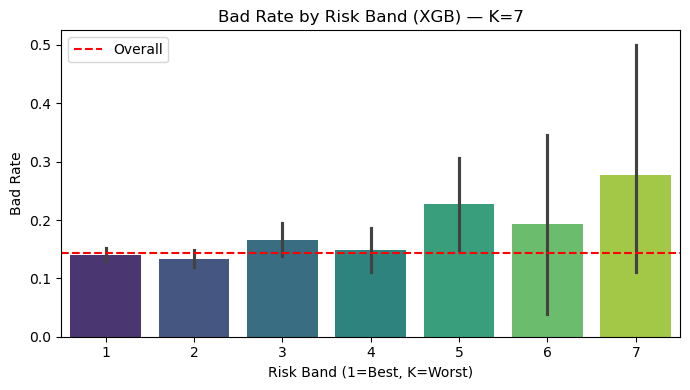

Testing AUC: 0.5306


In [11]:

# Artifacts directory from training stage
OUTPUT_DIR = Path('/home/ali/repos/creadit_risk/customer_segmantation/outputs2/customer_segmantation_unbaked_dtree_v1_datasource')
assert (OUTPUT_DIR / 'model_xgb.pkl').exists(), f"Missing model at {OUTPUT_DIR / 'model_xgb.pkl'}"
assert (OUTPUT_DIR / 'encoder_ordinal.pkl').exists(), f"Missing encoder at {OUTPUT_DIR / 'encoder_ordinal.pkl'}"
assert (OUTPUT_DIR / 'band_edges.txt').exists(), f"Missing band edges at {OUTPUT_DIR / 'band_edges.txt'}"

# Load artifacts
with open(OUTPUT_DIR / 'model_xgb.pkl', 'rb') as f:
    model = pickle.load(f)
with open(OUTPUT_DIR / 'encoder_ordinal.pkl', 'rb') as f:
    enc = pickle.load(f)

edges = np.loadtxt(OUTPUT_DIR / 'band_edges.txt', dtype=float)
edges = np.atleast_1d(edges)
K = len(edges) - 1
print(f"Loaded model with K={K} bands, edges: {np.round(edges, 4)}")

# Load testing data (same schema as training, but without target)
assert DATA_PATH.exists(), f"Testing data not found: {DATA_PATH}"
testing_df = pd.read_csv(DATA_PATH)
print('Loaded testing shape:', testing_df.shape)

# Feature columns used during training
categorical_cols = ['marital_status','address_category','jobtitle_category','gender']
numeric_cols = ['age','income_delta_percentage']

# Basic cleaning for categoricals to ensure encoder compatibility
for col in categorical_cols:
    testing_df[col] = testing_df[col].replace({None: np.nan, 'nan': np.nan, '': np.nan})
    testing_df[col] = testing_df[col].astype('object')

# Build features in the same order as training: [numeric..., encoded categorical...]
X_num = testing_df[numeric_cols].to_numpy()
X_cat = enc.transform(testing_df[categorical_cols])
X = np.hstack([X_num, X_cat])
print('Prepared testing data dimensions:', X.shape)

# Predict PD score
scored = testing_df.copy()
scored['pd_score'] = model.predict_proba(X)[:, 1]

# Assign band labels 1..K (1=best/lowest risk)
if K <= 0:
    scored['risk_band'] = 1
else:
    cat = pd.cut(scored['pd_score'], bins=edges, right=False, include_lowest=True)
    codes = cat.cat.codes.to_numpy()  # -1 for outside/NaN
    missing = int((codes < 0).sum())
    if missing:
        print(f"Warning: {missing} rows fell outside band edges; they will be imputed to nearest band.")
        vals = scored['pd_score'].to_numpy()
        codes = np.where(vals < edges[0], 0, codes)
        codes = np.where(vals >= edges[-1], K - 1, codes)
        codes = np.where(codes < 0, 0, codes)
    scored['risk_band'] = codes + 1

# For downstream compatibility, alias cluster = risk_band
scored['cluster'] = scored['risk_band']

# Save outputs
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
small_cols = ['customer_id', 'pd_score', 'risk_band', 'cluster']
available = [c for c in small_cols if c in scored.columns]
scored[available].to_csv(OUTPUT_DIR / 'testing_with_risk_bands.csv', index=False)
scored.to_csv(OUTPUT_DIR / 'testing_scored_full.csv', index=False)

# Quick summary
try:
    print(scored[['risk_band']].value_counts(normalize=False, dropna=False).sort_index())
except Exception:
    pass
print('Saved:', OUTPUT_DIR / 'testing_with_risk_bands.csv')
# visualize bad rate by band
plt.figure(figsize=(7,4))
order = sorted(scored['risk_band'].unique())
sns.barplot(data=scored, x='risk_band', y='target', order=order, palette='viridis')
plt.axhline(testing_df['target'].mean(), color='red', linestyle='--', label='Overall')
plt.xlabel('Risk Band (1=Best, K=Worst)')
plt.ylabel('Bad Rate')
plt.title(f'Bad Rate by Risk Band (XGB) — K={int(scored["risk_band"].nunique())}')
plt.legend()
plt.tight_layout()
plt.show()
# print AUC for testing 
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(scored['target'], scored['pd_score'])
print(f'Testing AUC: {auc:.4f}')


##### logistic regression 

Loaded model with K=7 bands, edges: [0.188 0.338 0.418 0.456 0.556 0.594 0.654 0.802]
Loaded testing shape: (6319, 8)
Prepared testing data dimensions: (6319, 6)
risk_band
1            6266
2              52
3               1
Name: count, dtype: int64
Saved: //home/ali/repos/creadit_risk/customer_segmantation/outputs/customer_segmentation_baked_logreg_bands_v1.0/testing_with_risk_bands.csv


/tmp/ipykernel_9177/3016410156.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=scored, x='risk_band', y='target', order=order, palette='viridis')


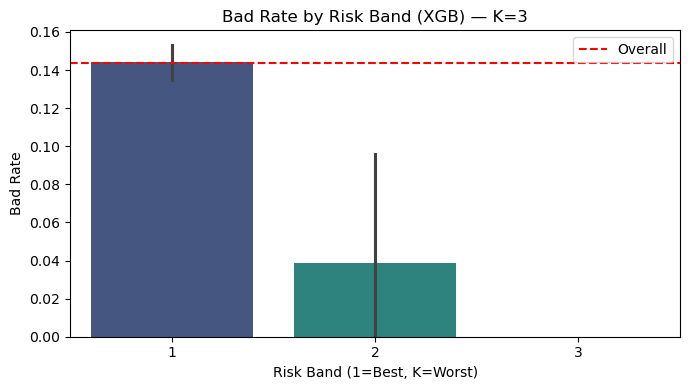

Testing AUC: 0.5057


In [5]:
# load logistic regression model 
OUTPUT_DIR = Path('//home/ali/repos/creadit_risk/customer_segmantation/outputs/customer_segmentation_baked_logreg_bands_v1.0')
assert (OUTPUT_DIR / 'model_logreg.pkl').exists(), f"Missing model at {OUTPUT_DIR / 'model_xgb.pkl'}"
assert (OUTPUT_DIR / 'encoder_ordinal.pkl').exists(), f"Missing encoder at {OUTPUT_DIR / 'encoder_ordinal.pkl'}"
assert (OUTPUT_DIR / 'band_edges.txt').exists(), f"Missing band edges at {OUTPUT_DIR / 'band_edges.txt'}"

# Load artifacts
with open(OUTPUT_DIR / 'model_logreg.pkl', 'rb') as f:
    model = pickle.load(f)
with open(OUTPUT_DIR / 'encoder_ordinal.pkl', 'rb') as f:
    enc = pickle.load(f)

edges = np.loadtxt(OUTPUT_DIR / 'band_edges.txt', dtype=float)
edges = np.atleast_1d(edges)
K = len(edges) - 1
print(f"Loaded model with K={K} bands, edges: {np.round(edges, 4)}")

# Load testing data (same schema as training, but without target)
assert DATA_PATH.exists(), f"Testing data not found: {DATA_PATH}"
testing_df = pd.read_csv(DATA_PATH)
print('Loaded testing shape:', testing_df.shape)

# Feature columns used during training
categorical_cols = ['marital_status','address_category','jobtitle_category','gender']
numeric_cols = ['age','income_delta_percentage']

# Basic cleaning for categoricals to ensure encoder compatibility
for col in categorical_cols:
    testing_df[col] = testing_df[col].replace({None: np.nan, 'nan': np.nan, '': np.nan})
    testing_df[col] = testing_df[col].astype('object')

# Build features in the same order as training: [numeric..., encoded categorical...]
X_num = testing_df[numeric_cols].to_numpy()
X_cat = enc.transform(testing_df[categorical_cols])
X = np.hstack([X_num, X_cat])
print('Prepared testing data dimensions:', X.shape)

# Predict PD score
scored = testing_df.copy()
scored['pd_score'] = model.predict_proba(X)[:, 1]

# Assign band labels 1..K (1=best/lowest risk)
if K <= 0:
    scored['risk_band'] = 1
else:
    cat = pd.cut(scored['pd_score'], bins=edges, right=False, include_lowest=True)
    codes = cat.cat.codes.to_numpy()  # -1 for outside/NaN
    missing = int((codes < 0).sum())
    if missing:
        print(f"Warning: {missing} rows fell outside band edges; they will be imputed to nearest band.")
        vals = scored['pd_score'].to_numpy()
        codes = np.where(vals < edges[0], 0, codes)
        codes = np.where(vals >= edges[-1], K - 1, codes)
        codes = np.where(codes < 0, 0, codes)
    scored['risk_band'] = codes + 1

# For downstream compatibility, alias cluster = risk_band
scored['cluster'] = scored['risk_band']

# Save outputs
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
small_cols = ['customer_id', 'pd_score', 'risk_band', 'cluster']
available = [c for c in small_cols if c in scored.columns]
scored[available].to_csv(OUTPUT_DIR / 'testing_with_risk_bands.csv', index=False)
scored.to_csv(OUTPUT_DIR / 'testing_scored_full.csv', index=False)

# Quick summary
try:
    print(scored[['risk_band']].value_counts(normalize=False, dropna=False).sort_index())
except Exception:
    pass
print('Saved:', OUTPUT_DIR / 'testing_with_risk_bands.csv')
# visualize bad rate by band
plt.figure(figsize=(7,4))
order = sorted(scored['risk_band'].unique())
sns.barplot(data=scored, x='risk_band', y='target', order=order, palette='viridis')
plt.axhline(testing_df['target'].mean(), color='red', linestyle='--', label='Overall')
plt.xlabel('Risk Band (1=Best, K=Worst)')
plt.ylabel('Bad Rate')
plt.title(f'Bad Rate by Risk Band (XGB) — K={int(scored["risk_band"].nunique())}')
plt.legend()
plt.tight_layout()
plt.show()
# print AUC for testing 
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(scored['target'], scored['pd_score'])
print(f'Testing AUC: {auc:.4f}')

#### dession tree 

Loaded dataset shape: (6319, 8)
Loaded model with feature names: ['age', 'income_delta_percentage', 'marital_status', 'address_category', 'jobtitle_category', 'gender']
Overall bad rate from summary: 0.1378690782775349
Prepared feature matrix shape: (6319, 6)
Unmapped leaves (should be 0): 0
Unique clusters found: [1, 2]
Assigned clusters, resulting shape: (6319, 9)
Leaf evaluation:


,leaf_id,size,pct,bad_rate,ci_low,ci_high,cluster
0,9,3483,0.551195,0.083262,0.074539,0.092903,1
1,10,2836,0.448805,0.103315,0.092644,0.115059,2


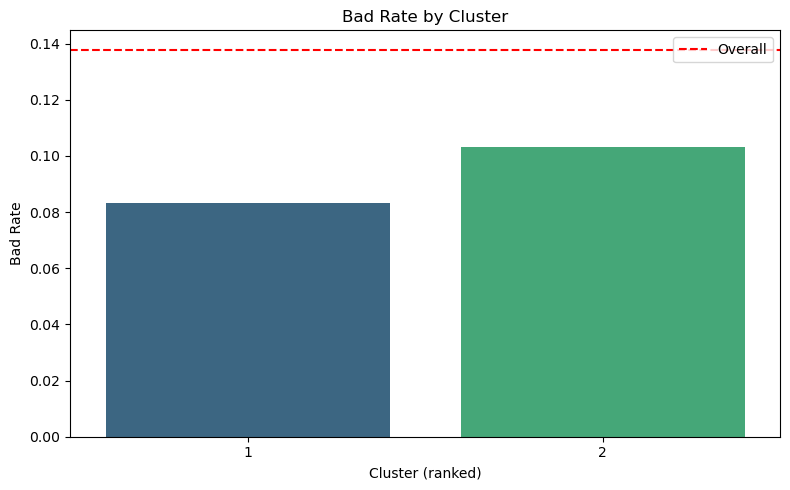

In [4]:
# Load tree and encoder for testing
import pickle
import json
from pathlib import Path
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Reuse the SAME feature preparation logic/order as training
from utiles import prepare_features, evaluate_leaf_bad_rates

MODEL_DIR = Path('customer_segmantation_unbaked_dtree_v1.0')
assert DATA_PATH.exists(), f"Dataset file not found: {DATA_PATH}"
assert MODEL_DIR.exists(), f"Model directory not found: {MODEL_DIR}"

df = pd.read_csv(DATA_PATH)

with open(MODEL_DIR / 'model_decision_tree.pkl', 'rb') as f:
    model: DecisionTreeClassifier = pickle.load(f)
with open(MODEL_DIR / 'encoder_ordinal.pkl', 'rb') as f:
    enc = pickle.load(f)
with open(MODEL_DIR / 'mapping_leaf_to_cluster.json', 'r') as f:
    leaf_id_to_cluster = json.load(f)
# JSON keys are strings; convert to ints to match model.apply() output
leaf_id_to_cluster = {int(k): int(v) for k, v in leaf_id_to_cluster.items()}

with open(MODEL_DIR / 'summary.json', 'r') as f:
    summary = json.load(f)

categorical_cols = summary['categorical_cols']
numeric_cols = summary['numeric_cols']
feature_names = summary['feature_names']
overall_bad_rate = summary['overall_bad_rate']

print('Loaded dataset shape:', df.shape)
print('Loaded model with feature names:', feature_names)
print('Overall bad rate from summary:', overall_bad_rate)

# --- Robust cleaning for categoricals before encoding ---
# Coerce to pandas StringDtype and impute missing with a sentinel so encoder.transform won't hit isnan on objects
for col in categorical_cols:
    if col not in df.columns:
        raise KeyError(f"Missing expected categorical column: {col}")
    df[col] = df[col].astype('string')
# Fill genuine missing values (NaN/NA) with a sentinel
df[categorical_cols] = df[categorical_cols].fillna('MISSING')
# Optional: strip whitespace to reduce spurious categories
for col in categorical_cols:
    df[col] = df[col].str.strip()
    df[col] = df[col].fillna('MISSING')

# Prepare features using SAME function and encoder as training (numeric first, then encoded categoricals)
X, y, _, _ = prepare_features(
    df,
    categorical_cols=categorical_cols,
    numeric_cols=numeric_cols,
    target_col='target',
    encoder=enc,
)
print('Prepared feature matrix shape:', X.shape)

# Apply model to assign clusters via leaf_id -> cluster mapping
leaf_id = model.apply(X)
clusters = np.vectorize(leaf_id_to_cluster.get)(leaf_id)

# Sanity checks
n_unmapped = int(np.sum(pd.isna(clusters)))
print(f'Unmapped leaves (should be 0): {n_unmapped}')
unique_clusters = pd.Series(clusters).dropna().unique()
print('Unique clusters found:', sorted(map(int, unique_clusters)))

testing_df = df.copy()
testing_df['cluster'] = clusters
print('Assigned clusters, resulting shape:', testing_df.shape)

# Evaluate leaf bad rates if target is available
if 'target' in testing_df.columns:
    df_eval, _, _ = evaluate_leaf_bad_rates(model, X, testing_df['target'].values)
    print('Leaf evaluation:')
    display(df_eval)
    # Visualize bad rates by cluster
    plt.figure(figsize=(8,5))
    order = df_eval.sort_values('bad_rate').cluster
    sns.barplot(data=df_eval, x='cluster', y='bad_rate', order=order, palette='viridis')
    plt.axhline(overall_bad_rate, color='red', linestyle='--', label='Overall')
    plt.ylabel('Bad Rate')
    plt.xlabel('Cluster (ranked)')
    plt.title('Bad Rate by Cluster')
    plt.legend()
    plt.tight_layout()
    plt.show()